### I replicate the results in Yin et al. (2018) which identified excitatory autapses in pyramidal cells.

#### 'Autapses enhance bursting and coincidence detection in neocortical pyramidal cells'. Yin et al, 2018
DOI: 10.1038/s41467-018-07317-4


Main results: 

autaptic contacts enhance burst firing (Fig. 6): Initial ISI is shorter with autapse present.
     
promote coincidence detection (fig. 7): A second current pulse 20ms after a first one was 
more likely to generate an AP if an autapse was present. 

In [ ]:
#Local imports

# Add directory of AQUA class to sys.path
import sys
sys.path.append('C:\\Users\\liamm\\Documents\\PhD_autapses\\Programming_files\\')


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from AQUA_class import AQUA
from plotting_functions import *

import seaborn as sns
sns.set_theme(style = "white")

## Fig. 6: Enhanced bursting

The initial two spikes are found to approach each other in time as the autaptic feedback is increased.
In fact, if the feedback is high enough, the neuron starts chattering.

In [2]:
# Large enough f will shift the behaviour of the system to bursting

# RS neuron parameters

a = 0.02
b = 0.2
c = -65
d = 8

#autaptic parameters
e = 1/3.3
f = 4 # or 8 [nS]
tau = 1.4 #ms

#simulation parameters
T = 1      # s
dt = 0.01   # ms
N_iter = int(T*1000/dt)

I_inj = np.concatenate([np.zeros(int(0.2*N_iter)), 10*np.ones(int(0.8*N_iter))])

Neuron_free = AQUA(a, b, c, d) # e, f, tau set to 0 automatically

Neuron_autapse = AQUA(a, b, c, d, e, f, tau)

# Initial values
x_start = np.array([-70., 0., 0.])
t_start = np.array([0.])

Neuron_free.Initialise(x_start, t_start)
Neuron_autapse.Initialise(x_start, t_start)


X_free, T_free, spikes_free = Neuron_free.update_RK2(dt, N_iter, I_inj)
X_autapse, T_autapse, spikes_autapse = Neuron_autapse.update_RK2(dt, N_iter, I_inj)

T_free /= 1000 # convert time to seconds
T_autapse /= 1000



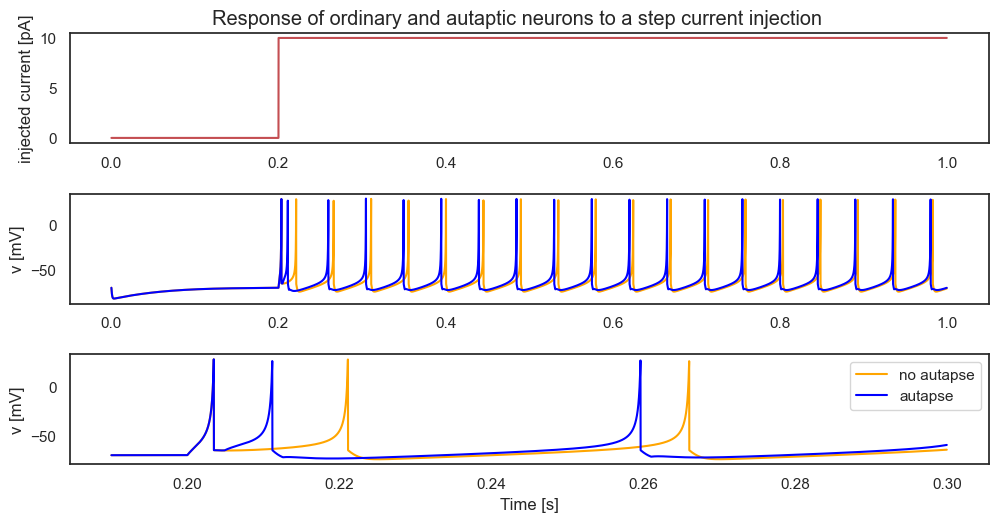

In [3]:
#plot
fig, ax = plt.subplots(3, 1, figsize = (10, 5))
fig.tight_layout()
indices = range(int(0.19*N_iter), int(0.3*N_iter))

ax[0].plot(T_free, I_inj, c = 'r')
#ax[0].title.set_text('injected current')
#ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('injected current [pA]')

ax[1].plot(T_free, X_free[0], c = 'orange')
ax[1].plot(T_free, X_autapse[0], c = 'blue')
#ax[1].title.set_text("Full response")
#ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('v [mV]')

ax[2].plot(T_free[indices], X_free[0, indices], c = 'orange', label = 'no autapse')
ax[2].plot(T_autapse[indices], X_autapse[0, indices], c = 'blue', label = 'autapse')
#ax[2].title.set_text("Full response")
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('v [mV]')
ax[2].legend()

fig.suptitle("Response of ordinary and autaptic neurons to a step current injection", y = 1)

plt.savefig(".\\Nov-2024_plots\\spike_train_f_16.png")


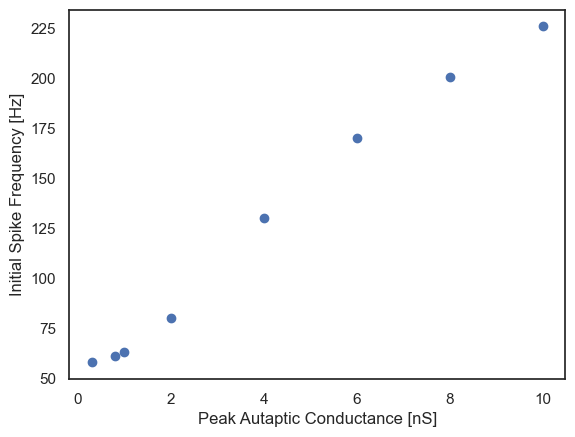

In [4]:
# for-loop will test the effect of different f values in the ISI of the first 2 spikes.
# Hopefully can be plotted to reproduce that plot in fig.6

# RS neuron parameters

#simulation parameters
T = 1      # s
dt = 0.01   # ms
N_iter = int(T*1000/dt)

# Injected current
I_inj = np.concatenate([np.zeros(int(0.2*N_iter)), 10*np.ones(int(0.8*N_iter))])

# Initial values
x_start = np.array([-70., 0., 0.])
t_start = np.array([0.])

#autaptic parameters
fs = [0.3, 0.8, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]

Initial_freq = []

for freq in fs:
    Neuron_autapse = AQUA(a, b, c, d, e, freq, tau)
    Neuron_autapse.Initialise(x_start, t_start)
    X_autapse, T_autapse, spikes_autapse = Neuron_autapse.update_RK2(dt, N_iter, I_inj)
    T_autapse /= 1000

    Initial_freq.append(1000/((spikes_autapse[1] - spikes_autapse[0]))) # in Hz


plt.scatter(fs, Initial_freq)
plt.xlabel('Peak Autaptic Conductance [nS]')
plt.ylabel('Initial Spike Frequency [Hz]')
# The discrepancy in the curve might be due to artificial autapse in the experiment having a noticeable rise time
# Also general discrepancies between both setups.

plt.savefig(".\\Nov-2024_plots\\ISI_vs_f.png")

## Fig. 7: Coincidence Detection

An Initial spike, which reliably produces a spike, is followed by a pulse, 20 ms later, which produces a spike 90% of the time in none-autaptic neurons.
Since this system is deterministic, we'll just test many values of I2 at different time delays.

This would demonstrate how the autapse affects the neuron's sensitivity to subsequent inputs.

In [9]:
#Simulation and neuron parameters.
# RS neuron parameters

#autaptic parameters, will stay fixed for now.

#simulation parameters
#T = 1      # s
dt = 0.01   # ms
#N_iter = int(T*1000/dt)

# Initial values
x_start = np.array([-70., 0., 0.])
t_start = np.array([0.])


# Injected current
I_1 = 4.75        # minimum to generate the first spike, for reference later.
I_2 = np.arange(15, 11, -0.25)
time_delays = np.arange(5, 105, 5) # time delays in ms, each ms is 100 steps in the simulation

spike_width = 0.005
pulse_duration = 5 # ms


# Define neurons.
Neuron_free = AQUA(a, b, c, d) # autapse free neuron
Neuron_autapse = AQUA(a, b, c, d, e, f, tau) #  autaptic neuron


# Wrong way to make a dataframe.
cols = ['I_2', 'time_delay', 'autapse', 'spike']
N_rows = 2*len(I_2)*len(time_delays)
np_data = np.zeros((N_rows, 4))
df = pd.DataFrame(data = np_data, columns = cols)



In [10]:
N = 0

for i in I_2:
    for j in time_delays:
        #Define the input current pulsed on new params.
        I_inj = np.concatenate([np.zeros(30000),
                                I_1*np.ones(int(pulse_duration/dt)), 
                                np.zeros(int(j/dt)), 
                                i*np.ones(int(pulse_duration/dt)), 
                                np.zeros(20000)])

        N_iter = np.shape(I_inj)[0]

        # Re-initialise for each run.
        Neuron_free.Initialise(x_start, t_start)        #  Initial values
        Neuron_autapse.Initialise(x_start, t_start)     #  initial values

        # Generate responses
        X_free, T_free, spikes_free = Neuron_free.update_RK2(dt, N_iter, I_inj)
        X_autapse, T_autapse, spikes_autapse = Neuron_autapse.update_RK2(dt, N_iter, I_inj)

        np_data[N]   = np.array([[i, j, 0, len(spikes_free)]])
        np_data[N+1] = np.array([[i, j, 1, len(spikes_autapse)]])
        
        N += 2
print(df)

       I_2  time_delay  autapse  spike
0    15.00         5.0      0.0    2.0
1    15.00         5.0      1.0    2.0
2    15.00        10.0      0.0    2.0
3    15.00        10.0      1.0    2.0
4    15.00        15.0      0.0    2.0
..     ...         ...      ...    ...
635  11.25        90.0      1.0    2.0
636  11.25        95.0      0.0    2.0
637  11.25        95.0      1.0    2.0
638  11.25       100.0      0.0    2.0
639  11.25       100.0      1.0    2.0

[640 rows x 4 columns]


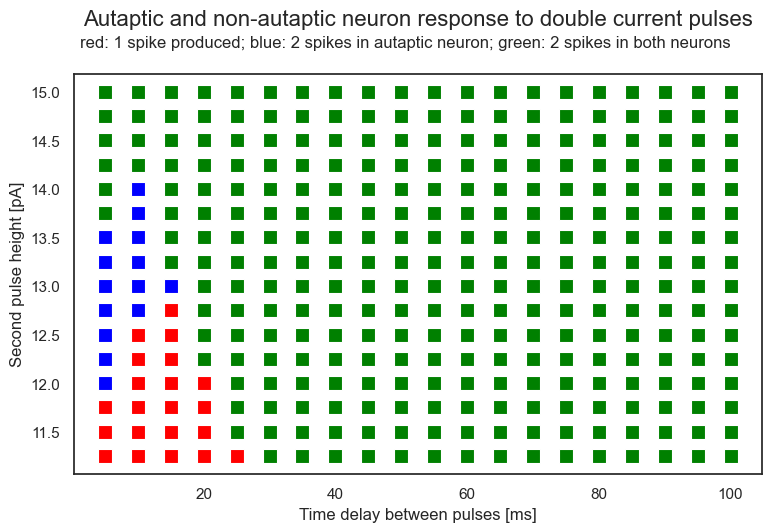

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
fig.tight_layout(pad = 2)
sns.scatterplot(data = df[(df['autapse'] == 0) & (df['spike'] == 1.)], x = 'time_delay', y = 'I_2', color = 'red', s = 100, marker = 's')
sns.scatterplot(data = df[(df['autapse'] == 1) & (df['spike'] == 2.)], x = 'time_delay', y = 'I_2', color = 'blue', s = 100, marker = 's')
sns.scatterplot(data = df[(df['autapse'] == 0) & (df['spike'] == 2.)], x = 'time_delay', y = 'I_2', color = 'green', s = 100, marker = 's')

plt.xlabel('Time delay between pulses [ms]')
plt.ylabel('Second pulse height [pA]')

plt.title('Autaptic and non-autaptic neuron response to double current pulses', y = 1.1, fontsize= 16)
plt.suptitle('red: 1 spike produced; blue: 2 spikes in autaptic neuron; green: 2 spikes in both neurons', y = 1.0, fontsize = 12)

plt.savefig(".\\Nov-2024_plots\\coincidence_detection.png")

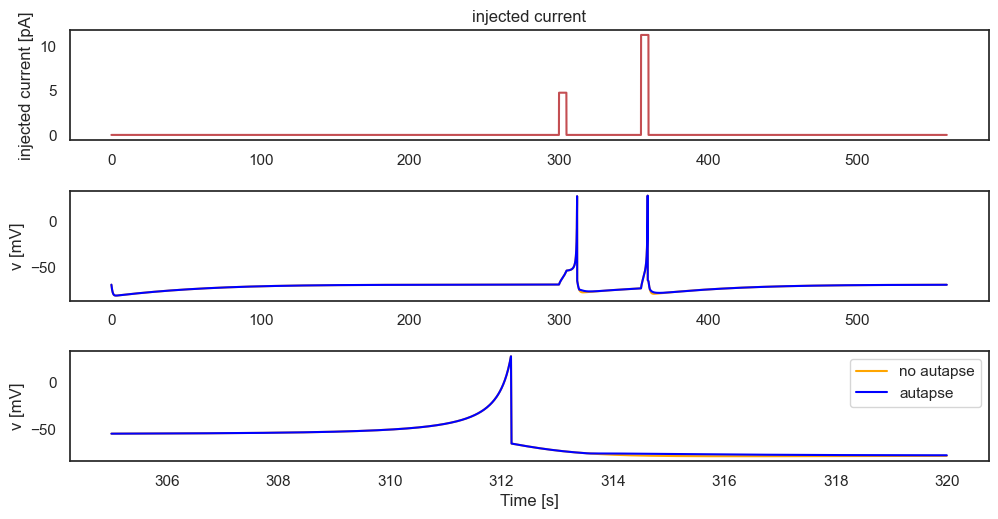

In [8]:
## For some reason, the exact same injected current produces a slight shift in the 
# initial spike. This shift seems to depend on the value of tau but 
# I can't see a mathematical reason for this.

#plot
fig, ax = plt.subplots(3, 1, figsize = (10, 5))
fig.tight_layout()
indices = range(30500, 32000)

ax[0].plot(T_free, I_inj, c = 'r')
ax[0].title.set_text('injected current')
#ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('injected current [pA]')

ax[1].plot(T_free, X_free[0], c = 'orange')
ax[1].plot(T_free, X_autapse[0], c = 'blue')
#ax[1].title.set_text("Full response")
#ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('v [mV]')

ax[2].plot(T_free[indices], X_free[0, indices], c = 'orange', label = 'no autapse')
ax[2].plot(T_autapse[indices], X_autapse[0, indices], c = 'blue', label = 'autapse')
#ax[2].title.set_text("Full response")
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('v [mV]')
ax[2].legend()